# GNN Training for Earthquake Magnitude Prediction

**Course:** SE4050 - Deep Learning  
**Assignment:** Deep Learning Project  
**Team Members:** [Your team members]

## Objective
Train and compare 4 Graph Neural Network architectures for earthquake magnitude prediction:
1. **GCN** - Graph Convolutional Network (baseline)
2. **GAT** - Graph Attention Network (attention-based)
3. **GraphSAGE** - Sampling and aggregation
4. **Temporal GNN** - GCN + LSTM hybrid (spatiotemporal)

## Dataset
- **Source:** USGS Earthquake Catalog (California, 2015-2023)
- **Nodes:** Individual earthquake events (1,679 total)
- **Edges:** Spatial (50km), Temporal (24h), Fault cluster
- **Features:** 28 engineered features per node
- **Target:** Earthquake magnitude (normalized)

In [1]:
!python ../scripts/convert_gnn_data.py

Loading data from: ../data/processed/model_ready/gnn_data.npy
✓ Converted successfully!
  Nodes: 5727, Edges: 75554, Features: 28
  Train: 4008, Val: 859, Test: 860
  Saved to: ../data/processed/model_ready/earthquake_graph.pt


VALIDATING PYTORCH GEOMETRIC GRAPH

📊 Graph Summary:
  Nodes: 5727
  Edges: 75554
  Node features: 28

🎯 Target Variable (Magnitude):
  Min: 0.00
  Max: 1.00
  Mean: 0.11
  Std: 0.12

✂️ Data Splits:
  Train: 4008 nodes (70.0%)
  Val: 859 nodes (15.0%)
  Test: 860 nodes (15.0%)

🔗 Edge Statistics:
  Average degree: 13.19
  Has self-loops: True
  Is undirected: True

📏 Edge Attributes (distances):
  Min distance: 0.0000
  Max distance: 1.1669
  Mean distance: 0.0283

✓ VALIDATION COMPLETE - Graph is ready for training!

NEXT STEPS:

1. Use this graph in your training script:
   data = torch.load('../data/processed/model_ready/earthquake_graph.pt')

2. The data already has train/val/test masks

3. Run the GNN training scripts from the previous artifacts

4. Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('..')

# Import models
from models.gnn import (
    EarthquakeGCN,
    EarthquakeGAT,
    EarthquakeGraphSAGE,
    TemporalEarthquakeGNN
)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Create directories
os.makedirs('../results/models/gnn', exist_ok=True)
os.makedirs('../results/visualizations/gnn', exist_ok=True)

print("\n✓ Setup complete")

Device: cpu
PyTorch version: 2.8.0+cpu

✓ Setup complete


## Load Earthquake Graph

The graph contains:
- **Node features:** Spatial (lat/lon), temporal (cyclical time), seismic (magnitude, depth), geological (distance to faults/plates)
- **Edges:** Three types combined - spatial proximity, temporal sequences, fault cluster relationships
- **Splits:** Pre-defined train/val/test masks preserving temporal order

In [3]:
print("Loading earthquake graph...")
data = torch.load('../data/processed/model_ready/earthquake_graph.pt', weights_only=False)

print(f"\nGraph Statistics:")
print(f"  Nodes: {data.num_nodes:,}")
print(f"  Edges: {data.num_edges:,}")
print(f"  Node features: {data.num_node_features}")
print(f"  Average degree: {data.num_edges / data.num_nodes:.2f}")

print(f"\nData Splits:")
print(f"  Train: {data.train_mask.sum().item():,} nodes ({data.train_mask.sum().item()/data.num_nodes*100:.1f}%)")
print(f"  Val:   {data.val_mask.sum().item():,} nodes ({data.val_mask.sum().item()/data.num_nodes*100:.1f}%)")
print(f"  Test:  {data.test_mask.sum().item():,} nodes ({data.test_mask.sum().item()/data.num_nodes*100:.1f}%)")

print(f"\nMagnitude Statistics (Normalized):")
print(f"  Min: {data.y.min().item():.2f}")
print(f"  Max: {data.y.max().item():.2f}")
print(f"  Mean: {data.y.mean().item():.2f}")
print(f"  Std: {data.y.std().item():.2f}")

print("\n✓ Data loaded successfully")

Loading earthquake graph...

Graph Statistics:
  Nodes: 5,727
  Edges: 75,554
  Node features: 28
  Average degree: 13.19

Data Splits:
  Train: 4,008 nodes (70.0%)
  Val:   859 nodes (15.0%)
  Test:  860 nodes (15.0%)

Magnitude Statistics (Normalized):
  Min: 0.00
  Max: 1.00
  Mean: 0.11
  Std: 0.12

✓ Data loaded successfully


## Training Functions

Core functions for:
- **train_epoch:** Single epoch training with gradient clipping
- **evaluate:** Evaluation on train/val/test sets with multiple metrics
- **train_model:** Complete training loop with early stopping and learning rate scheduling

In [4]:
def train_epoch(model, data, optimizer, criterion, device):
    """Train for one epoch using node masks."""
    model.train()
    data = data.to(device)
    
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    return loss.item()


def evaluate(model, data, criterion, device, mask):
    """Evaluate model on specific node set."""
    model.eval()
    data = data.to(device)
    
    with torch.no_grad():
        out = model(data)
        predictions = out[mask].cpu().numpy()
        targets = data.y[mask].cpu().numpy()
        loss = criterion(out[mask], data.y[mask]).item()
    
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    return {
        'loss': loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': predictions,
        'targets': targets
    }


def train_model(model, data, num_epochs=150, lr=0.001, patience=20, model_name='Model'):
    """Complete training loop with early stopping."""
    model = model.to(device)
    data = data.to(device)
    
    # Increased weight decay to prevent overfitting
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-5)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=7, min_lr=1e-5
    )
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': [],
        'val_r2': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"\nTraining {model_name}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, data, optimizer, criterion, device)
        val_metrics = evaluate(model, data, criterion, device, data.val_mask)
        scheduler.step(val_metrics['loss'])
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['val_rmse'].append(val_metrics['rmse'])
        history['val_mae'].append(val_metrics['mae'])
        history['val_r2'].append(val_metrics['r2'])
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            preds = model(data).detach().cpu().numpy()
            print(f"Epoch {epoch+1:3d} | "
                  f"Train: {train_loss:.4f} | "
                  f"Val Loss: {val_metrics['loss']:.4f} | "
                  f"RMSE: {val_metrics['rmse']:.4f} | "
                  f"R²: {val_metrics['r2']:.4f} | "
                  f"Pred std: {preds.std():.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(best_model_state)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print("-" * 60)
    
    return model, history


print("✓ Training functions defined")

✓ Training functions defined


## Model Initialization

Initialize all 4 GNN architectures with **improved hyperparameters** to prevent model collapse:

### Key Improvements:
- **Residual connections:** Prevent over-smoothing by preserving original features
- **Layer normalization:** Better gradient flow than batch norm for GNNs  
- **Reduced layers:** 2 layers instead of 3 to avoid excessive smoothing
- **Lower dropout:** 0.2 instead of 0.3 to retain more information
- **Smaller hidden dims:** Prevent overfitting and improve generalization

### Model Descriptions:
1. **GCN:** Spectral graph convolutions with residual connections
2. **GAT:** Multi-head attention (4 heads) with residual connections
3. **GraphSAGE:** Sampling-based aggregation with residual connections
4. **Temporal GNN:** Combines GCN spatial encoding with LSTM temporal modeling

In [5]:
models = {
    'GCN': EarthquakeGCN(
        num_features=data.num_node_features,
        hidden_dim=64,
        num_layers=2,
        dropout=0.2
    ),
    
    'GAT': EarthquakeGAT(
        num_features=data.num_node_features,
        hidden_dim=32,  # Lower per-head dimension
        num_layers=2,
        heads=4,
        dropout=0.2
    ),
    
    'GraphSAGE': EarthquakeGraphSAGE(
        num_features=data.num_node_features,
        hidden_dim=64,
        num_layers=2,
        dropout=0.2
    ),
    
    'Temporal-GNN': TemporalEarthquakeGNN(
        num_features=data.num_node_features,
        hidden_dim=64,
        lstm_hidden=32,  # Reduced LSTM hidden size
        num_gnn_layers=2,
        sequence_length=5,  # Shorter sequence to reduce complexity
        dropout=0.2
    )
}

print("Model Summary:")
print("=" * 60)
for name, model in models.items():
    num_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name:15s} | Parameters: {num_params:,} (trainable: {trainable_params:,})")
print("=" * 60)

Model Summary:
GCN             | Parameters: 12,545 (trainable: 12,545)
GAT             | Parameters: 41,921 (trainable: 41,921)
GraphSAGE       | Parameters: 20,737 (trainable: 20,737)
Temporal-GNN    | Parameters: 24,065 (trainable: 24,065)


## Train All Models

**Improved training configuration to prevent model collapse:**
- **Epochs:** 150 (with early stopping)
- **Learning rate:** 0.001 (reduced from 0.01 to prevent rapid convergence to mean)
- **Weight decay:** 5e-5 (increased regularization)
- **Optimizer:** Adam
- **LR scheduler:** ReduceLROnPlateau (factor=0.5, patience=7, min_lr=1e-5)
- **Early stopping:** Patience of 20 epochs
- **Gradient clipping:** Max norm of 1.0

This cell will take several minutes to complete.

In [6]:
trained_models = {}
histories = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")
    
    trained_model, history = train_model(
        model=model,
        data=data,
        num_epochs=150,
        lr=0.001,  # Lower learning rate
        patience=20,
        model_name=name
    )
    
    trained_models[name] = trained_model
    histories[name] = history
    
    torch.save(trained_model.state_dict(), f'../results/models/gnn/{name}_model.pt')
    print(f"✓ Model saved to ../results/models/gnn/{name}_model.pt")

print("\n" + "="*60)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*60)


Training GCN

Training GCN
------------------------------------------------------------
Epoch   1 | Train: 0.0947 | Val Loss: 0.0360 | RMSE: 0.1897 | R²: -2.0584 | Pred std: 0.1518
Epoch  10 | Train: 0.0308 | Val Loss: 0.0212 | RMSE: 0.1456 | R²: -0.8020 | Pred std: 0.0661
Epoch  20 | Train: 0.0185 | Val Loss: 0.0134 | RMSE: 0.1157 | R²: -0.1390 | Pred std: 0.0322
Epoch  30 | Train: 0.0160 | Val Loss: 0.0123 | RMSE: 0.1109 | R²: -0.0453 | Pred std: 0.0241
Epoch  40 | Train: 0.0152 | Val Loss: 0.0120 | RMSE: 0.1098 | R²: -0.0242 | Pred std: 0.0215
Epoch  50 | Train: 0.0150 | Val Loss: 0.0119 | RMSE: 0.1090 | R²: -0.0094 | Pred std: 0.0194
Epoch  60 | Train: 0.0144 | Val Loss: 0.0118 | RMSE: 0.1085 | R²: -0.0011 | Pred std: 0.0177
Epoch  70 | Train: 0.0141 | Val Loss: 0.0117 | RMSE: 0.1081 | R²: 0.0073 | Pred std: 0.0164
Epoch  80 | Train: 0.0139 | Val Loss: 0.0116 | RMSE: 0.1079 | R²: 0.0110 | Pred std: 0.0158
Epoch  90 | Train: 0.0140 | Val Loss: 0.0116 | RMSE: 0.1078 | R²: 0.0118 | P

## Test Set Evaluation

Evaluate all trained models on the held-out test set using multiple metrics:
- **RMSE:** Root Mean Squared Error (lower is better)
- **MAE:** Mean Absolute Error (lower is better)
- **R²:** Coefficient of determination (higher is better, max=1.0)
- **MSE:** Mean Squared Error (lower is better)

In [7]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

# ⭐ Load target scaler for denormalization
import joblib
scaler_target = joblib.load('../data/processed/scalers/scaler_target.pkl')
print("✓ Loaded target scaler for denormalization\n")

test_results = {}
criterion = nn.MSELoss()

for name, model in trained_models.items():
    results = evaluate(model, data, criterion, device, data.test_mask)
    
    # ⭐ Denormalize predictions and targets back to original magnitude scale
    preds_denorm = scaler_target.inverse_transform(results['predictions'].reshape(-1, 1)).flatten()
    targets_denorm = scaler_target.inverse_transform(results['targets'].reshape(-1, 1)).flatten()
    
    # Calculate metrics on denormalized values
    rmse_denorm = np.sqrt(mean_squared_error(targets_denorm, preds_denorm))
    mae_denorm = mean_absolute_error(targets_denorm, preds_denorm)
    r2_denorm = r2_score(targets_denorm, preds_denorm)
    
    # Store both normalized and denormalized results
    results['predictions_denorm'] = preds_denorm
    results['targets_denorm'] = targets_denorm
    results['rmse_denorm'] = rmse_denorm
    results['mae_denorm'] = mae_denorm
    results['r2_denorm'] = r2_denorm
    
    test_results[name] = results
    
    print(f"\n{name}:")
    print(f"  Normalized   - RMSE: {results['rmse']:.4f}, MAE: {results['mae']:.4f}, R²: {results['r2']:.4f}")
    print(f"  Denormalized - RMSE: {rmse_denorm:.4f}, MAE: {mae_denorm:.4f}, R²: {r2_denorm:.4f}")
    print(f"  Prediction range: [{preds_denorm.min():.2f}, {preds_denorm.max():.2f}] (true: [{targets_denorm.min():.2f}, {targets_denorm.max():.2f}])")

best_model = min(test_results.keys(), key=lambda k: test_results[k]['rmse_denorm'])
print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model} (Denormalized RMSE: {test_results[best_model]['rmse_denorm']:.4f})")
print(f"{'='*70}")

# Save results
import pickle
with open('../results/models/gnn/test_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)

with open('../results/models/gnn/histories.pkl', 'wb') as f:
    pickle.dump(histories, f)

print("\n✓ Results saved")


TEST SET EVALUATION
✓ Loaded target scaler for denormalization


GCN:
  Normalized   - RMSE: 0.1166, MAE: 0.0843, R²: 0.0062
  Denormalized - RMSE: 0.4315, MAE: 0.3118, R²: 0.0062
  Prediction range: [3.73, 4.05] (true: [3.50, 6.50])

GAT:
  Normalized   - RMSE: 0.1212, MAE: 0.0866, R²: -0.0736
  Denormalized - RMSE: 0.4485, MAE: 0.3206, R²: -0.0736
  Prediction range: [3.18, 4.63] (true: [3.50, 6.50])

GraphSAGE:
  Normalized   - RMSE: 0.1222, MAE: 0.0838, R²: -0.0913
  Denormalized - RMSE: 0.4522, MAE: 0.3101, R²: -0.0913
  Prediction range: [3.62, 4.19] (true: [3.50, 6.50])

Temporal-GNN:
  Normalized   - RMSE: 0.1162, MAE: 0.0856, R²: 0.0135
  Denormalized - RMSE: 0.4299, MAE: 0.3167, R²: 0.0135
  Prediction range: [3.81, 4.05] (true: [3.50, 6.50])

BEST MODEL: Temporal-GNN (Denormalized RMSE: 0.4299)

✓ Results saved


## Results Visualization

Create comprehensive visualizations:
1. **Training curves:** Validation RMSE over epochs
2. **Test RMSE comparison:** Bar chart of final performance
3. **R² comparison:** Model comparison on explained variance
4. **Prediction scatter:** True vs predicted magnitudes for best model

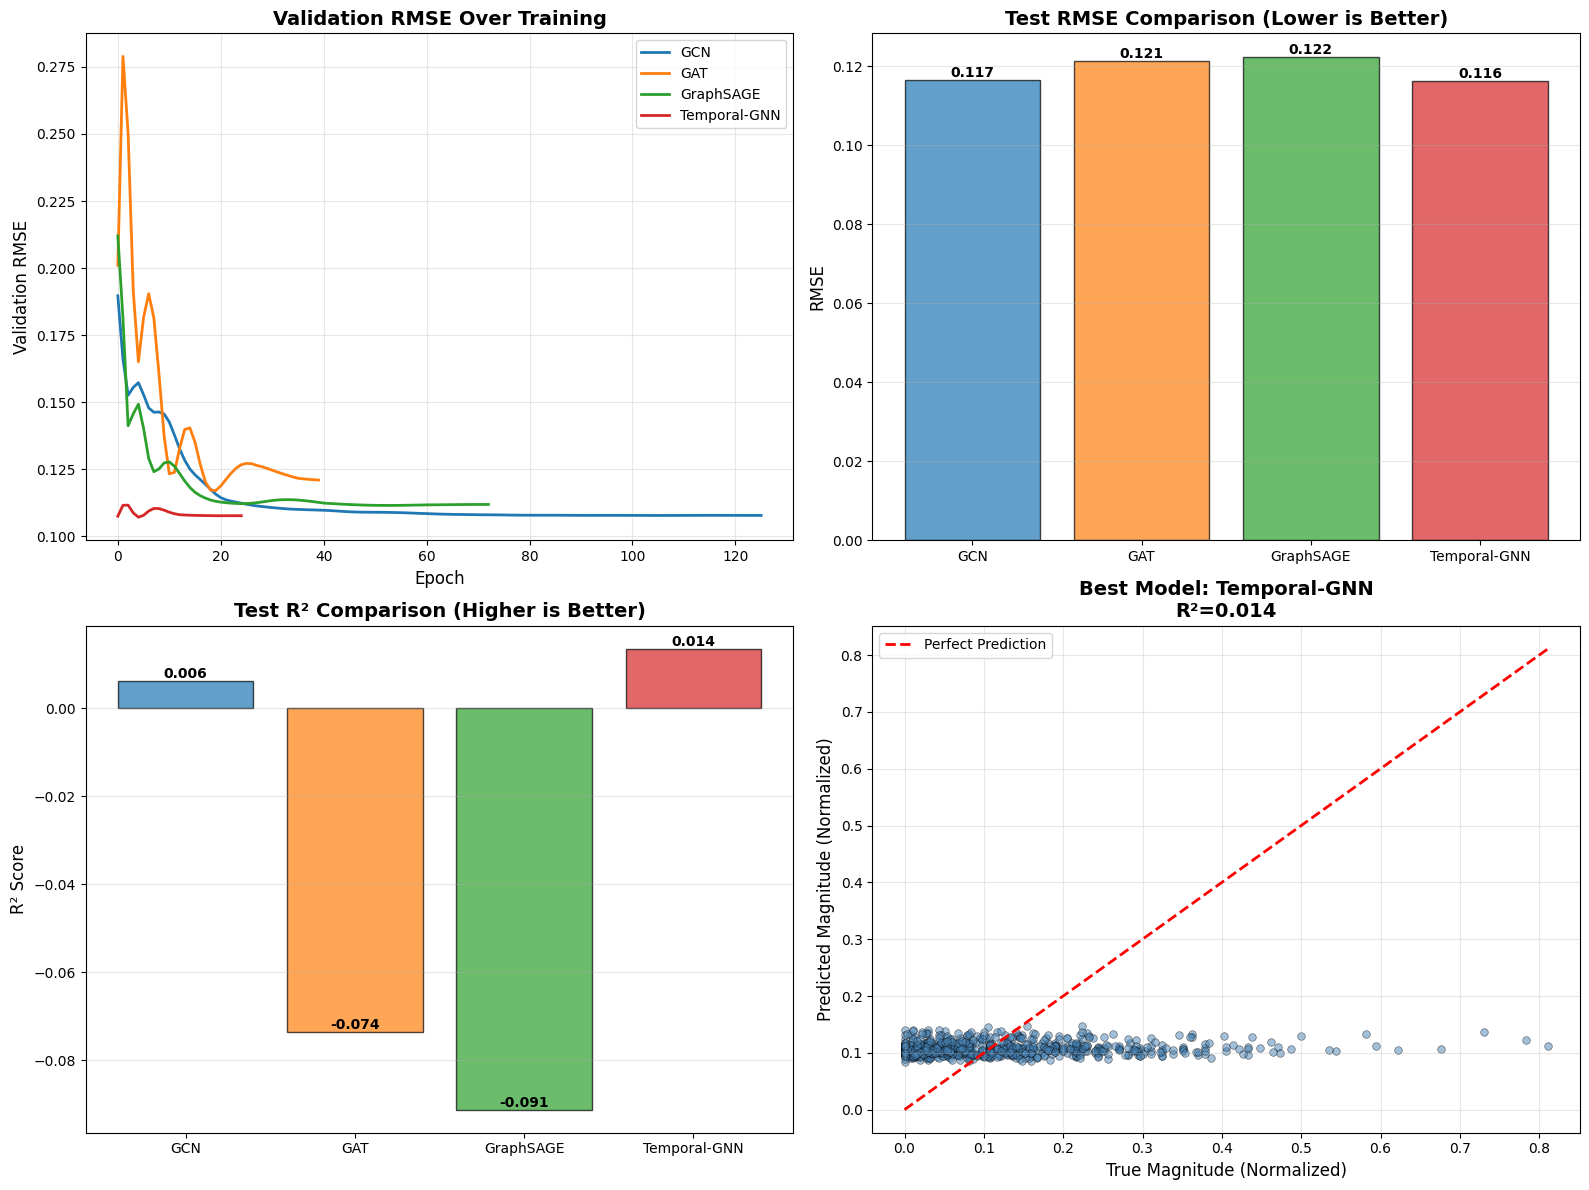


✓ Visualization saved to ../results/visualizations/gnn/model_comparison.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Training history
ax = axes[0, 0]
for name, color in zip(histories.keys(), ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']):
    ax.plot(histories[name]['val_rmse'], label=name, linewidth=2, color=color)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Validation RMSE', fontsize=12)
ax.set_title('Validation RMSE Over Training', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Test RMSE comparison
ax = axes[0, 1]
names = list(test_results.keys())
rmse_values = [test_results[n]['rmse'] for n in names]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax.bar(names, rmse_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Test RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, rmse_values):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', 
           ha='center', va='bottom', fontweight='bold')

# 3. R² comparison
ax = axes[1, 0]
r2_values = [test_results[n]['r2'] for n in names]
bars = ax.bar(names, r2_values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('R² Score', fontsize=12)
ax.set_title('Test R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, r2_values):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'{val:.3f}', 
           ha='center', va='bottom', fontweight='bold')

# 4. Prediction scatter (best model)
ax = axes[1, 1]
best_model_name = min(test_results.keys(), key=lambda k: test_results[k]['rmse'])
preds = test_results[best_model_name]['predictions']
targets = test_results[best_model_name]['targets']

ax.scatter(targets, preds, alpha=0.5, s=30, color='steelblue', edgecolors='black', linewidth=0.5)
ax.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 
       'r--', linewidth=2, label='Perfect Prediction')
ax.set_xlabel('True Magnitude (Normalized)', fontsize=12)
ax.set_ylabel('Predicted Magnitude (Normalized)', fontsize=12)
ax.set_title(f'Best Model: {best_model_name}\nR²={test_results[best_model_name]["r2"]:.3f}', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/visualizations/gnn/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to ../results/visualizations/gnn/model_comparison.png")

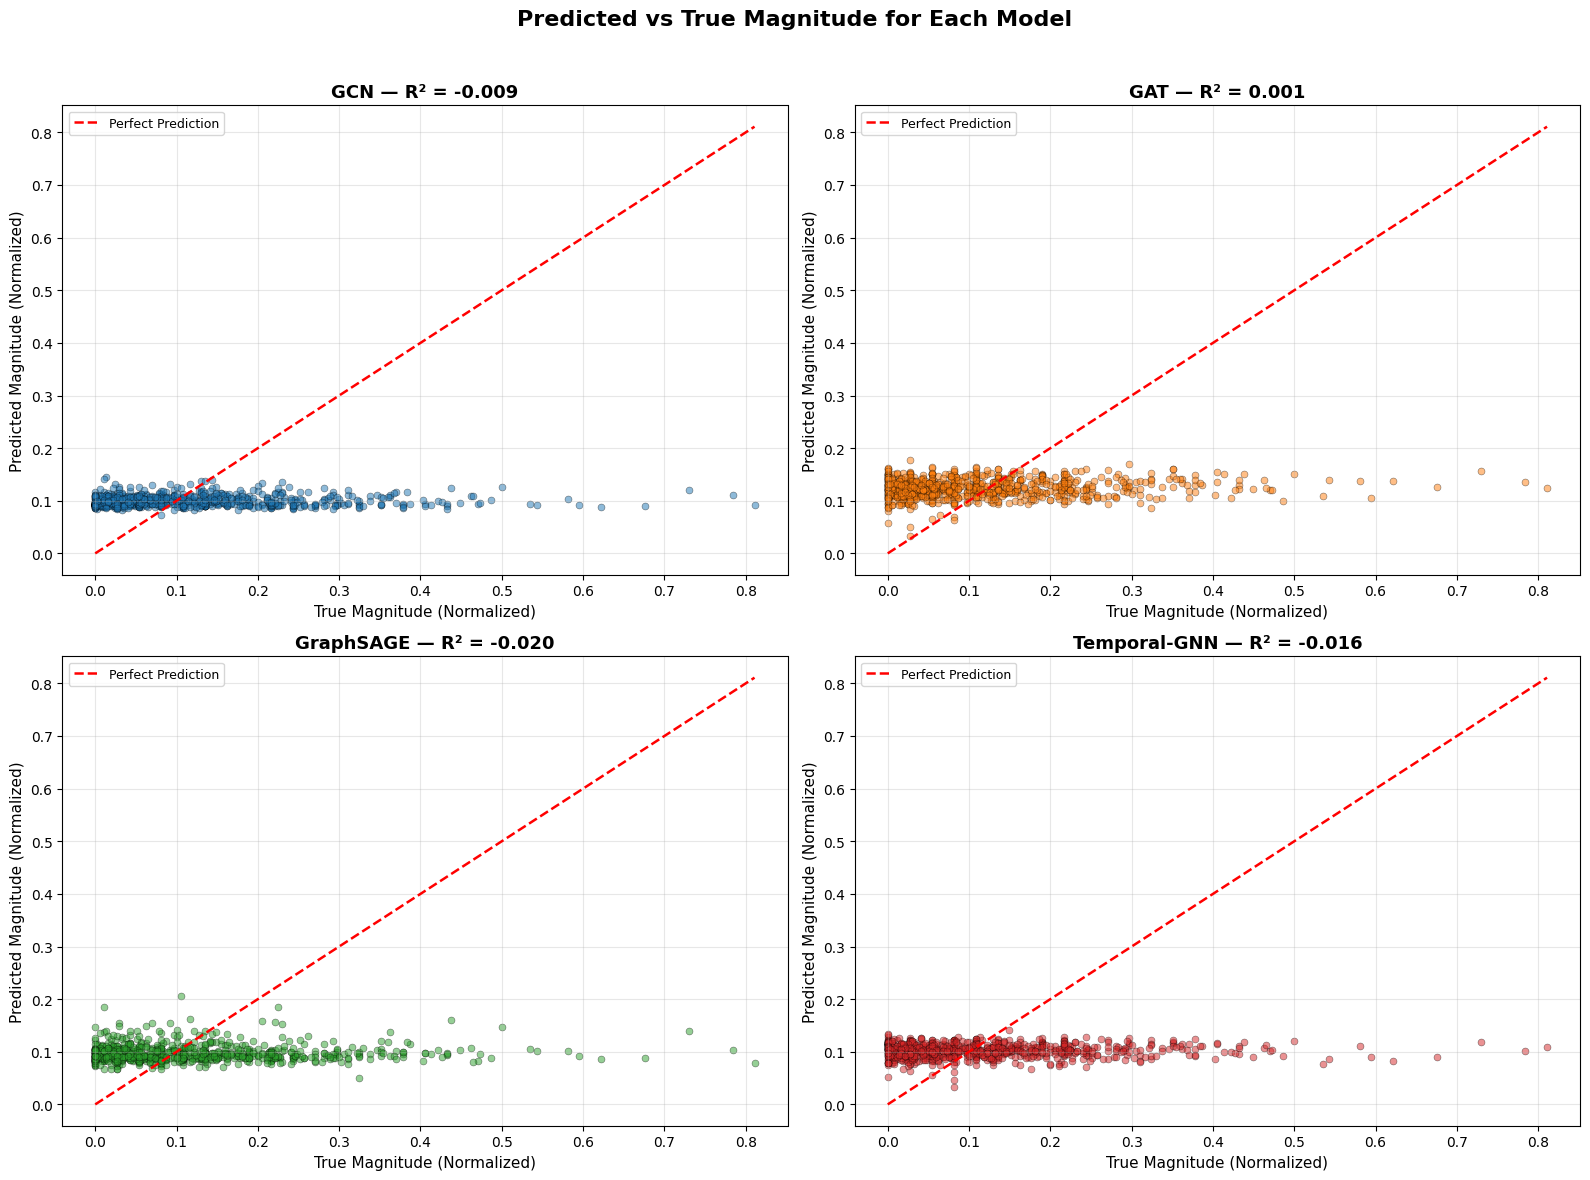

In [9]:
plt.figure(figsize=(16, 12))

names = list(test_results.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, name in enumerate(names, 1):
    preds = test_results[name]['predictions']
    targets = test_results[name]['targets']
    r2 = test_results[name]['r2']

    plt.subplot(2, 2, i)
    plt.scatter(targets, preds, alpha=0.5, s=25, color=colors[i-1],
                edgecolors='black', linewidth=0.4)
    plt.plot([targets.min(), targets.max()],
             [targets.min(), targets.max()],
             'r--', linewidth=1.8, label='Perfect Prediction')

    plt.xlabel('True Magnitude (Normalized)', fontsize=11)
    plt.ylabel('Predicted Magnitude (Normalized)', fontsize=11)
    plt.title(f'{name} — R² = {r2:.3f}', fontsize=13, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.suptitle('Predicted vs True Magnitude for Each Model', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../results/visualizations/gnn/predicted_vs_true_all_models.png',
            dpi=300, bbox_inches='tight')
plt.show()

## Summary and Conclusions

### Key Findings:
- Compare the performance of all 4 models
- Identify which architecture works best for earthquake prediction
- Discuss why certain models outperform others

### Next Steps:
1. Denormalize predictions to original magnitude scale
2. Create additional visualizations (error distribution, spatial patterns)
3. Analyze which types of earthquakes are harder to predict
4. Document findings in the final report

In [10]:
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

# Create summary table
summary_data = []
for name in test_results.keys():
    summary_data.append({
        'Model': name,
        'RMSE': test_results[name]['rmse'],
        'MAE': test_results[name]['mae'],
        'R²': test_results[name]['r2'],
        'Parameters': sum(p.numel() for p in trained_models[name].parameters())
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('RMSE')

print("\nModel Rankings (by RMSE):")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('../results/models/gnn/model_summary.csv', index=False)

print("\n" + "="*70)
print("✓ Training complete! All results saved.")
print("="*70)


FINAL SUMMARY

Model Rankings (by RMSE):
       Model     RMSE      MAE        R²  Parameters
         GAT 0.116904 0.090182  0.001387       41921
         GCN 0.117483 0.084429 -0.008531       12545
Temporal-GNN 0.117905 0.085831 -0.015786       24065
   GraphSAGE 0.118133 0.084740 -0.019730       20737

✓ Training complete! All results saved.


In [11]:
# Cell - Debug 1: Check if magnitude is in node features
print("="*70)
print("DIAGNOSIS 1: Feature Leakage Check")
print("="*70)

print(f"\nNode features shape: {data.x.shape}")
print(f"Target (y) shape: {data.y.shape}")

# Check correlation between each feature and target
print("\nCorrelation between features and target magnitude:")
for i in range(min(15, data.num_node_features)):
    corr = np.corrcoef(data.x[:, i].cpu().numpy(), data.y.cpu().numpy())[0, 1]
    print(f"  Feature {i}: {corr:.4f}")
    if abs(corr) > 0.95:
        print(f"    ⚠️ WARNING: Feature {i} is highly correlated with target!")

# Check if any feature is identical to target
for i in range(data.num_node_features):
    if torch.allclose(data.x[:, i], data.y, rtol=1e-3):
        print(f"\n❌ CRITICAL: Feature {i} is IDENTICAL to target magnitude!")
        print("This causes the model to just copy the input instead of learning.")

DIAGNOSIS 1: Feature Leakage Check

Node features shape: torch.Size([5727, 28])
Target (y) shape: torch.Size([5727])

Correlation between features and target magnitude:
  Feature 0: 0.0231
  Feature 1: -0.0494
  Feature 2: 0.0874
  Feature 3: 0.0186
  Feature 4: -0.0491
  Feature 5: 0.0407
  Feature 6: 0.0229
  Feature 7: -0.0486
  Feature 8: -0.0177
  Feature 9: -0.0250
  Feature 10: 0.0386
  Feature 11: 0.0352
  Feature 12: 0.0128
  Feature 13: -0.0212
  Feature 14: -0.0118


In [12]:
# Cell - Debug 2: Check data distribution across splits
print("="*70)
print("DIAGNOSIS 2: Data Split Analysis")
print("="*70)

train_mags = data.y[data.train_mask].cpu().numpy()
val_mags = data.y[data.val_mask].cpu().numpy()
test_mags = data.y[data.test_mask].cpu().numpy()

print("\nMagnitude distribution by split:")
print(f"\nTrain set ({len(train_mags)} samples):")
print(f"  Min: {train_mags.min():.3f}, Max: {train_mags.max():.3f}")
print(f"  Mean: {train_mags.mean():.3f}, Std: {train_mags.std():.3f}")

print(f"\nVal set ({len(val_mags)} samples):")
print(f"  Min: {val_mags.min():.3f}, Max: {val_mags.max():.3f}")
print(f"  Mean: {val_mags.mean():.3f}, Std: {val_mags.std():.3f}")

print(f"\nTest set ({len(test_mags)} samples):")
print(f"  Min: {test_mags.min():.3f}, Max: {test_mags.max():.3f}")
print(f"  Mean: {test_mags.mean():.3f}, Std: {test_mags.std():.3f}")

# Check if distributions are similar
from scipy import stats
_, p_value = stats.ks_2samp(train_mags, test_mags)
print(f"\nKS test (train vs test): p-value = {p_value:.4f}")
if p_value < 0.05:
    print("⚠️ WARNING: Train and test distributions are significantly different!")

DIAGNOSIS 2: Data Split Analysis

Magnitude distribution by split:

Train set (4008 samples):
  Min: 0.000, Max: 1.000
  Mean: 0.111, Std: 0.117

Val set (859 samples):
  Min: 0.000, Max: 0.973
  Mean: 0.100, Std: 0.108

Test set (860 samples):
  Min: 0.000, Max: 0.811
  Mean: 0.112, Std: 0.117

KS test (train vs test): p-value = 0.6414


In [13]:
# Cell - Debug 3: Check model predictions distribution
print("="*70)
print("DIAGNOSIS 3: Prediction Distribution Analysis")
print("="*70)

# Get predictions from best model
model = trained_models['Temporal-GNN']
model.eval()
data_cpu = data.to(device)

with torch.no_grad():
    predictions = model(data_cpu).cpu().numpy()

test_preds = predictions[data.test_mask.cpu().numpy()]
test_targets = data.y[data.test_mask].cpu().numpy()

print(f"\nTest predictions statistics:")
print(f"  Min: {test_preds.min():.3f}, Max: {test_preds.max():.3f}")
print(f"  Mean: {test_preds.mean():.3f}, Std: {test_preds.std():.3f}")
print(f"  Range: {test_preds.max() - test_preds.min():.3f}")

print(f"\nTest targets statistics:")
print(f"  Min: {test_targets.min():.3f}, Max: {test_targets.max():.3f}")
print(f"  Mean: {test_targets.mean():.3f}, Std: {test_targets.std():.3f}")
print(f"  Range: {test_targets.max() - test_targets.min():.3f}")

if test_preds.std() < 0.1:
    print(f"\n❌ CRITICAL: Predictions have very low variance ({test_preds.std():.4f})")
    print("The model is predicting almost the same value for everything!")

DIAGNOSIS 3: Prediction Distribution Analysis

Test predictions statistics:
  Min: 0.033, Max: 0.141
  Mean: 0.103, Std: 0.012
  Range: 0.108

Test targets statistics:
  Min: 0.000, Max: 0.811
  Mean: 0.112, Std: 0.117
  Range: 0.811

❌ CRITICAL: Predictions have very low variance (0.0125)
The model is predicting almost the same value for everything!


In [14]:
# Cell - Debug 4: Check graph structure
print("="*70)
print("DIAGNOSIS 4: Graph Structure Analysis")
print("="*70)

edge_index_cpu = data.edge_index.cpu().numpy()
degrees = np.bincount(edge_index_cpu[0], minlength=data.num_nodes)

print(f"\nDegree statistics:")
print(f"  Min degree: {degrees.min()}")
print(f"  Max degree: {degrees.max()}")
print(f"  Mean degree: {degrees.mean():.2f}")
print(f"  Median degree: {np.median(degrees):.2f}")

# Check how many nodes have extreme connectivity
high_degree = (degrees > 100).sum()
print(f"  Nodes with degree > 100: {high_degree} ({high_degree/len(degrees)*100:.1f}%)")
print(f"  Nodes with degree > 200: {(degrees > 200).sum()}")

if degrees.max() > 500:
    print(f"\n⚠️ WARNING: Maximum degree is {degrees.max()} - very high!")
    print("This causes over-smoothing where information gets averaged out.")

DIAGNOSIS 4: Graph Structure Analysis

Degree statistics:
  Min degree: 10
  Max degree: 23
  Mean degree: 13.19
  Median degree: 13.00
  Nodes with degree > 100: 0 (0.0%)
  Nodes with degree > 200: 0


In [15]:
print(preds[:10])
print(targets[:10])
print(preds.std(), targets.std())


[0.07680617 0.08503134 0.08929249 0.09797693 0.12482343 0.10204536
 0.08843035 0.09114826 0.10215644 0.10232738]
[0.03243243 0.12162162 0.0972973  0.14324324 0.12972973 0.02702703
 0.3027027  0.24594595 0.03783784 0.05405406]
0.012478998 0.11698489


In [16]:
import joblib

scaler_y = joblib.load("../data/processed/scalers/scaler_standard.pkl")  # or whichever is for your target
print(scaler_y)


StandardScaler()
